In [1]:
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)

[nltk_data] Error loading reuters: <urlopen error Remote end closed
[nltk_data]     connection without response>


In [2]:
def read_corpus(category="crude"):
    """
    Read files from specified Reuter's category
    params:
            category(string): category name
    return:
            list of lists,with words from each of processed files
    """
    files=reuters.fileids(category)
    return [[START_TOKEN]+[w.lower() for w in list(reuters.words(f))]+[END_TOKEN] for f in files]
    

In [3]:
reuters_corpus=read_corpus()
pprint.pprint(reuters_corpus[:3],compact=True,width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

In [4]:
def distinct_word(corpus):
    """
    Determine a list of distinct words for the corpus
    Params:
            corpus(list of list of strings) corpus of document
    Return：
            corpus_words(list of strings):list of distinct word across the corpus  sorted (using python sorted function)
            num_corpus_words(interge):number of distinct words across the corpus
    """
    corpus_words=[]
    num_corpus_words=-1
    
    temp=[y for x in corpus for y in x ]
    temp=list(set(temp))
    temp.sort() #千万不能写成 temp=temp.sort(),这样temp就变成了NONEtype
    corpus_words=temp
    num_corpus_words=len(corpus_words)
#     corpus_words = list(set([word for words in corpus for word in words]))
#     corpus_words.sort()
#     num_corpus_words = len(corpus_words)
    
    return corpus_words,num_corpus_words

In [5]:
# --------------------------------------
# Run this sanity check
#Note that this not an exhaustive check for correctness.
#---------------------------------------

#Define toy corpus
test_corpus=["{} All that glitters isn't gold {}".format(START_TOKEN,END_TOKEN).split(" "),"{} All's well that end's well {}".format(START_TOKEN,END_TOKEN).split(" ")]
test_corpus_words,test_num_corpus_words=distinct_word(test_corpus)

#Correct answers
ans_test_corpus_words=sorted([START_TOKEN,END_TOKEN,"All","All's","end's","glitters","gold","isn't","that",'well'])
ans_test_num_corpus_words=len(ans_test_corpus_words)

#Test correct number of words
assert(test_num_corpus_words==ans_test_num_corpus_words),"Incoerrect number of distinct word.Correct {},Yous :{}.".format(test_num_corpus_words,ans_test_num_corpus_words)

#Test correct words
assert(test_corpus_words==ans_test_corpus_words),"Incorrect corpus words\n Correct:{}\n Yours {}.".format(test_corpus_words,ans_test_corpus_words)

print('-'*80)
print("Pass All Test!!!!")
print('-'*80)


--------------------------------------------------------------------------------
Pass All Test!!!!
--------------------------------------------------------------------------------


In [6]:
def compute_co_occurrence_matrix(corpus,window_size=4):
    """
    Compute cooccurence matrix for the given corpus and window size (default of 4)
    Note : Each word in a documnet should be at the center of a window.Words near edges will have a smaller
            number of co-occurence words
            For example if we take the document "<START> All that glitters is not gold <END>" with window size of
            4 All with co-occurence <START> that glitters is not
    params : 
        corpus (list of list of strings ):corpus of document
        window_size :size of content window
    Return  :
        M(a symmetric numpy matrix of shape (number of unique word in the  corpus number of unique words in the corpus )):
        Co-occurence matrix of word count
        The orders of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
        word2Ind (dict):dictionary that maps word toindex (i.e row/column number )for matrix M
    """
    """
    构建共现矩阵思路
    + 首先根据distinct_word函数生成列表构造单词到ID的Word的字典word2Ind
    + 在从预料库取出一篇文档 遍历该文档 并逐词进行判断 再次遍历该文档 并逐词判断 如若该词位于
    + 首次遍历词的窗口内 在共现矩阵的合适位置加一 否则跳出遍历 。
    + 如若找到窗口词 则根据Word2ind字典找到该词的索引 进而找到共现矩阵的位置
    """
    corpus_words,num_corpus_words=distinct_word(corpus)
    M=np.zeros((num_corpus_words,num_corpus_words))
    word2Ind={word:i for i,word in enumerate(corpus_words)}
    
    for words in corpus:  #
        for i,word in enumerate(words):
            for j in range(i-window_size,i+window_size+1):
                if j==i or j<0 or j>=len(words): continue
                else:
                    row=word2Ind[word]
                    col=word2Ind[words[j]]
                    M[row,col]+=1
    return M,word2Ind
                

In [7]:
#------------------------------------------------------
#Run this sanity cjeck
#Note that this is not an exhaustive for correctness
#------------------------------------------------------

#Denfine toy corpus and get student's co-occurance matrix
test_corpus=["{} All that glitters isn't gold {}".format(START_TOKEN,END_TOKEN).split(" "),"{} All's well that ends well {}".format(START_TOKEN,END_TOKEN).split(" ")]
M_test,word2Ind_test=compute_co_occurrence_matrix(test_corpus,window_size=1)

#print(M_test)
#correct M and word2Ind
M_test_ans=np.array([[0.,0.,0.,0.,0.,0.,1.,0.,0.,1.],
      [0.,0.,1.,1.,0.,0.,0.,0.,0.,0.],
      [0.,1.,0.,0.,0.,0.,0.,0.,1.,0.],
      [0.,1.,0.,0.,0.,0.,0.,0.,0.,1.],
      [0.,0.,0.,0.,0.,0.,0.,0.,1.,1.],
      [0.,0.,0.,0.,0.,0.,0.,1.,1.,0.],
      [1.,0.,0.,0.,0.,0.,0.,1.,0.,0.],
      [0.,0.,0.,0.,0.,1.,1.,0.,0.,0.],
      [0.,0.,1.,0.,1.,1.,0.,0.,0.,1.],
      [1.,0.,0.,1.,1.,0.,0.,0.,1.,0.] ])

ans_test_corpus_words=sorted([START_TOKEN,END_TOKEN,"All","All's","ends","glitters","gold","isn't","that",'well'])

word2Ind_ans=dict(zip(ans_test_corpus_words,range(len(ans_test_corpus_words))))


 
#Test word2Ind is correct
assert(word2Ind_ans==word2Ind_test),"Yours word2Ind is incorrect:\n Yours: {}\n Correct: {}".format(word2Ind_test,word2Ind_ans)

#Test correct M.shape
assert(M_test.shape==M_test_ans.shape),"You M.shape is incorrect :\n Your :{}\n Correct:{} ".format(M_test.shape,M_test_ans.shape)

#Test correct M values

for w1 in word2Ind_test.keys():
    idx1=word2Ind_test[w1]
    for w2 in word2Ind_test.keys():
        idx2=word2Ind_test[w2]
        student=M_test[idx1,idx2]
        correct=M_test_ans[idx1,idx2]
        if student!=correct:
            print("Your M:\n")
            print(M_test)
            print("correct M:\n")
            print(M_test_ans)
            raise AssertionError("Incorrect count at index  ({},{})=({},{}) in M matrix You has {} but correct {}!".format(idx1,idx2,w1,w2,student,correct))
            


# success pass test
print("-*"*40)
print("Pass All Test!!!!!!!")
print("-*"*40)
            

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Pass All Test!!!!!!!
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


In [8]:
def reduce_to_k_dim(M,k=2):
    """
    Reduce co-occurrence count of  matrix dimensionality(num_corpus_words,num_corpus_words)
    to a matrix of dimensionality (num_corpus_words,k) using the following SVD function from sklearn
    
    Params:
    M:(numpy matrix of shape (number of unqiue words in the corpus,number of unique words in the corpus))
    k(size) int: embedding size of each word after dimension reducation
    
    Return:
    M_reduce:(numpy matrix of shape (num_corpus_words,k)):matrix of k-dimensionality word embedding
    In term of math class ,this actually return U*S
    
    """ 
    n_iters=10
    M_reduce=np.zeros((M.shape[0],k))
    print("Running TruncatedSVD over %i words ....."%(M.shape[0]))
    svd=TruncatedSVD(n_components=k,n_iter=n_iters)
    M_reduce=svd.fit_transform(M) #这里要用fit_transform函数
                                  #fit函数返回的是transfrom对象 fit_transform函数返回的才是降维后的数组
    
    print("Done!")
    
    return M_reduce
    
    

In [9]:
#----------------------------------------
#Run this sanity check
#Note that this is not exhaustive check for the correctness
#In fact we only check that you M_reduce has the right dimensions
#-----------------------------------------

#Define toy corpus and run student code
test_corpus=["{} All that glitter isn't gold {}".format(START_TOKEN,END_TOKEN).split(" "),"{} All's well that ends well {}".format(START_TOKEN,END_TOKEN).split(" ")]
M_test,word2Ind_test=compute_co_occurrence_matrix(test_corpus,window_size=1)
M_reduce_test=reduce_to_k_dim(M_test,k=2)

#Test proper dimensional
assert(M_reduce_test.shape[0]==10),  "M_reduce has {} rows, should have {}".format(M_reduce_test.shape[0],10)
assert(M_reduce_test.shape[1]==2),  "M_reduce has {} cols,should have {}".format(M_reduce_test.shape[1],2)

#Pass the test
print('+'*80)
print(" Pass All Test!!!!!! ")
print('+'*80)

Running TruncatedSVD over 10 words .....
Done!
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 Pass All Test!!!!!! 
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [32]:
def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    for word in words:
        idx=word2Ind[word]
        plt.scatter(M_reduced[idx][0],M_reduced[idx][1],marker='x',color='red')
        plt.text(M_reduced[idx][0]+0.003,M_reduced[idx][1]+0.003,word,fontsize=9)
    plt.show()

--------------------------------------------------------------------------------
Outputted Plot:


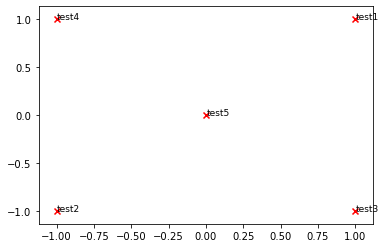

--------------------------------------------------------------------------------


In [33]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

print ("-" * 80)

Running TruncatedSVD over 8185 words .....
Done!


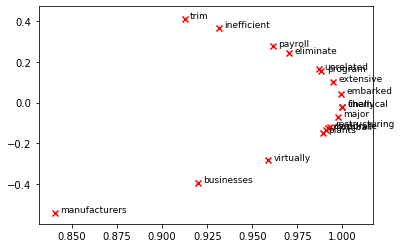

In [34]:
#-----------------------------------
#Run the cell plot your answer
#-----------------------------------
reuters_corpus=read_corpus()
M_co_occurence,word2Ind_co_occurence=compute_co_occurrence_matrix(reuters_corpus)

M_reduced_co_occurence=reduce_to_k_dim(M_co_occurence)

#Normlization
M_lengths=np.linalg.norm(M_reduced_co_occurence,axis=1)
M_nomalized=M_reduced_co_occurence/M_lengths[:,np.newaxis]

words=['finally',  'virtually', 'major', 
  'chemical', 'manufacturers', 'embarked',  'extensive', 'corporate',
  'restructuring', 'program',  'mothball', 'inefficient', 'plants',  'trim',
  'payroll','eliminate', 'unrelated', 'businesses']
plot_embeddings(M_nomalized,word2Ind_co_occurence,words)


In [13]:
def load_embedding_model():
    """
    Load Glove Vectors
    Return 
    wv_from_bin:All 400000 emdeddings each length 200
    """
    import gensim.downloader as api
    wv_from_bin=api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" %len(wv_from_bin.vocab.keys()))
    return wv_from_bin

In [14]:
#----------------------------------
#Run cell to Load Word Vector
#----------------------------------
wv_from_bin=load_embedding_model()

[==================================================] 100.0% 252.1/252.1MB downloaded
Loaded vocab size 400000


In [18]:
def get_matrix_of_vectors(wv_from_bin,required_words=['barrels','bpd','ecuador','energy','industry','kuwait',
                                                     'oil','output','petroleum','venezuela']):
    """
    Put the Glove vectors into a matrix M
    Params:
            wv_from_bin:KeyedVectors object ; the 40000 GloVe vectors from file
    Return :
            M numpy matrix shape (num_word ,200) contain the vectors
            word2Ind:dictionary mapping each word to its row number in M       
    """
    import random 
    words =list(wv_from_bin.vocab.keys())
    print("shuffling word....")
    random.seed(224)
    random.shuffle(words)
    words=words[:10000]
    print("Putting %i words into word2Ind and matrix M..."%len(words))
    word2Ind={}
    M=[]
    curInd=0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w]=curInd
            curInd+=1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w]=curInd
            curInd+=1
        except KeyError:
            continue
    M=np.stack(M)
    print('Done!')
    return M,word2Ind

In [29]:
#----------------------------------------------
#Run cell to reduce 200-Dimensional word Emeddings to K dimensional
#----------------------------------------------
M,word2Ind=get_matrix_of_vectors(wv_from_bin)
M_reduced=reduce_to_k_dim(M,k=2)

#Recale (normalize) the rows to make them each of  unit_length
M_lengths=np.linalg.norm(M_reduced,axis=1)
M_reduced_normalized=M_reduced/M_lengths[:,np.newaxis]

shuffling word....
Putting 10000 words into word2Ind and matrix M...
Done!
Running TruncatedSVD over 10010 words .....
Done!


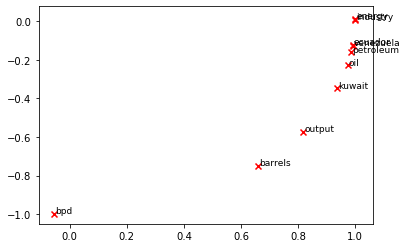

In [39]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced_normalized,word2Ind,words)
#plot_embeddings(M_nomalized,word2Ind_co_occurence,words)

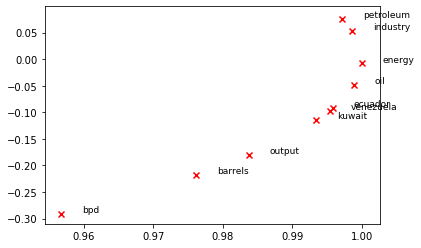

In [37]:

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_nomalized,word2Ind_co_occurence,words)

## 比较共现矩阵和GloVe向量得到可视化图
+ GloVe向量比共现矩阵结果同类型词向量更聚集
## 分析原因
+ Glove向量训练考虑上下文语义 因此相似词向量他们的相关性更大

## Question 2.2: Polysemous Words (2 points) [code + written] 
Find a [polysemous](https://en.wikipedia.org/wiki/Polysemy) word (for example, "leaves" or "scoop") such that the top-10 most similar words (according to cosine similarity) contains related words from *both* meanings. For example, "leaves" has both "vanishes" and "stalks" in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous words before you find one. Please state the polysemous word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous words you tried didn't work?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [42]:
wv_from_bin.most_similar('compute')

[('calculate', 0.699090838432312),
 ('computed', 0.61522376537323),
 ('algorithm', 0.5691111087799072),
 ('formula_1', 0.5609829425811768),
 ('formula_3', 0.5595877766609192),
 ('formula_4', 0.5565686821937561),
 ('computes', 0.5493069887161255),
 ('formula_2', 0.5455579161643982),
 ('formula_7', 0.5447344779968262),
 ('nodes', 0.5444777011871338)]

## 结果分析
+ 因为most_similar函数是根据待求词与词库中所有词的cosine 所以对compute进行most_similar得到到大部分都是与
+ 计算有关的
+ 发现第三个是algorithm和后面的formula_X 发现compute也有公式算法的意思

### Question 2.3: Synonyms & Antonyms (2 points) [code + written] 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful". 

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

## Cosine Distance=1-Consine Similarity 

In [51]:
synonyms=wv_from_bin.distance("happy","cheerful")
antonyms=wv_from_bin.distance('happy','sad')
print('synonyms Cosine Distance:{},antonyms :{}'.format(synonyms,antonyms))

synonyms Cosine Distance:0.5172466933727264,antonyms :0.4040136933326721


In [54]:
synonyms=wv_from_bin.distance('succeed','win')
antonyms=wv_from_bin.distance('succeed','failed')
print('synonyms Cosine Distance:{},antonyms :{}'.format(synonyms,antonyms))

synonyms Cosine Distance:0.6058680415153503,antonyms :0.5829358696937561


##  结果分析
+ succeed与failed表示一件事情的结果 要么成功 要么失败
+ succeed与win都表示成功
+ 在一个语境下同时出现succeed与win可能性很低 但是同时出现succeed和failed可能性也比较di
+ 但是比前者来比要搞

### Solving Analogies with Word Vectors
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : king :: woman : x" (read: man is to king as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x. The `most_similar` function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list. The answer to the analogy will be the word ranked most similar (largest numerical value).

**Note:** Further Documentation on the `most_similar` function can be found within the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__. 

In [57]:
pprint.pprint(wv_from_bin.most_similar(positive=['woman','king'],negative=['man']))

[('queen', 0.6978678703308105),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998854637146),
 ('elizabeth', 0.546359658241272),
 ('daughter', 0.5399125814437866),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164472460746765)]


### Question 2.4: Finding Analogies [code + written]  (2 Points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [60]:
pprint.pprint(wv_from_bin.most_similar(positive=['man','daughter'],negative=['woman']))

[('son', 0.859366238117218),
 ('brother', 0.8229293823242188),
 ('father', 0.7971405982971191),
 ('nephew', 0.7398903965950012),
 ('cousin', 0.7232843041419983),
 ('uncle', 0.7157564759254456),
 ('sons', 0.7103796601295471),
 ('grandson', 0.7086800336837769),
 ('eldest', 0.6781379580497742),
 ('grandfather', 0.6770942807197571)]


### 结果分析
woman:daughter :: man :son 

### Question 2.5: Incorrect Analogy [code + written] (1 point)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [64]:
pprint.pprint(wv_from_bin.most_similar(positive=['wrong','pass'],negative=['right']))

[('passing', 0.5922626256942749),
 ('passes', 0.5581673383712769),
 ('mistake', 0.5209980010986328),
 ('passed', 0.487493097782135),
 ('kick', 0.47384369373321533),
 ('anyway', 0.45854517817497253),
 ('unfortunately', 0.4506814479827881),
 ('way', 0.44923853874206543),
 ('caught', 0.44642940163612366),
 ('stupid', 0.44124168157577515)]


In [66]:
pprint.pprint(wv_from_bin.distance('right','pass'))
pprint.pprint(wv_from_bin.distance('wrong','fail'))

0.4726331830024719
0.5369578301906586


### 结果分析
+ right：pass :: wrong :fail
+ 结果却是各种通过

### Question 2.6: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [68]:
#Run this cell
# Here positive indicates the list of words to be similar to and the negative indicates the list of words tobe
# most dissimilar to
pprint.pprint(wv_from_bin.most_similar(positive=['man','worker'],negative=['woman']))
pprint.pprint(wv_from_bin.most_similar(positive=['woman','worker'],negative=['man']))

[('workers', 0.6113258004188538),
 ('employee', 0.5983108282089233),
 ('working', 0.5615328550338745),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.5368517637252808),
 ('job', 0.5278826951980591),
 ('work', 0.5223963260650635),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.505452036857605),
 ('factory', 0.4940453767776489)]
[('employee', 0.6375863552093506),
 ('workers', 0.6068919897079468),
 ('nurse', 0.5837947726249695),
 ('pregnant', 0.5363885164260864),
 ('mother', 0.5321309566497803),
 ('employer', 0.5127025842666626),
 ('teacher', 0.5099576711654663),
 ('child', 0.5096741914749146),
 ('homemaker', 0.5019454956054688),
 ('nurses', 0.4970572590827942)]


### 结果分析
+ 男性列表中多为一些与工作有关的单词还包括劳动者和技工等单词
+ 女性列表中多为与家庭有关的单词还有一些女性工作比较多的职业比如护士、老师、家庭主妇
+ 在训练预料的都来源现实生活中的场景，所以进行训练是男性的工作的上下文多为劳动有关的词汇
+ 女性的工作的上下文多为护士、妈妈、家庭主妇等词汇

### Question 2.7: Independent Analysis of Bias in Word Vectors [code + written]  (1 point)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [69]:
pprint.pprint(wv_from_bin.most_similar(positive=['man','boss'],negative=['woman']))
pprint.pprint(wv_from_bin.most_similar(positive=['woman','boss'],negative=['man']))

[('bosses', 0.5625280141830444),
 ('manager', 0.5502104759216309),
 ('ferguson', 0.49866554141044617),
 ('arsene', 0.4745480716228485),
 ('gambino', 0.4580872058868408),
 ('wenger', 0.45207348465919495),
 ('mourinho', 0.4470241069793701),
 ('tottenham', 0.4417468011379242),
 ('chelsea', 0.43944650888442993),
 ('mafia', 0.4386819005012512)]
[('bosses', 0.5846002697944641),
 ('girlfriend', 0.5496258735656738),
 ('wife', 0.48936721682548523),
 ('mistress', 0.47348833084106445),
 ('boyfriend', 0.4683173894882202),
 ('tells', 0.46039485931396484),
 ('mother', 0.4581165313720703),
 ('daughter', 0.45619285106658936),
 ('lover', 0.4546445608139038),
 ('husband', 0.44650694727897644)]


### 结果分析：
+ 当知道女人是老板时 去推断男人身份 得到大多为人名或者管理者
+ 当知道男人是老板时 去推断女人身份 得到大多数为女朋友，妈妈，爱人等与我们认知的结果相差有点远

In [71]:
pprint.pprint(wv_from_bin.most_similar(positive=['human','black'],negative=['white']))
pprint.pprint(wv_from_bin.most_similar(positive=['human','white'],negative=['black']))

[('rights', 0.6323614120483398),
 ('beings', 0.5802987813949585),
 ('animal', 0.5394347906112671),
 ('humanity', 0.5326052904129028),
 ('humans', 0.5177587270736694),
 ('life', 0.5034070014953613),
 ('body', 0.5030037760734558),
 ('freedom', 0.49023717641830444),
 ('people', 0.4858167767524719),
 ('causes', 0.4795451760292053)]
[('rights', 0.5797088146209717),
 ('animal', 0.5609157681465149),
 ('humans', 0.5117975473403931),
 ('administration', 0.5001749396324158),
 ('beings', 0.5001029968261719),
 ('animals', 0.492091566324234),
 ('any', 0.4777699112892151),
 ('nature', 0.47246524691581726),
 ('abuses', 0.4724014401435852),
 ('clinton', 0.4694903492927551)]


### Question 2.8: Thinking About Bias [written] (2 points)¶
What might be the causes of these biases in the word vectors? You should give least 2 explainations how bias get into the word vectors. How might you be able to investigate/test these causes?

### 分析
+ 这样的偏见主要来自训练预料 训练预料有来自现实世界
+ 所以这偏见与现实世界的偏见吻合
+ 还有就是根据word2ve的原理也可以看出这样结果的合理性 训练的时候考虑上下文
+ 而上下文有都是这样的关系 最终学的模型也现实这样的结果